# Capsone Part 2 - EDA and Data Tranformation - Dmitri Kazanski

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time  
import ast
import pytz

from scipy.stats import chi2_contingency

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV

In [2]:
data = pd.read_csv(r"C:\Users\dkaza\Documents\0 Berkeley - ML and AI\0_Capstone\undersampled_data.csv")

In [3]:
data.head()

,Unnamed: 0,request_last_seen_os,request_os_version,request_make,request_model,request_form_factor,request_source,request_country,request_placement_id,request_publisher_id,...,user_num_conversions_d30,user_num_conversions_d90,user_num_bundles_installed_d90,user_num_bundles_seen_on_d90,user_is_converter,user_is_clicker,user_primary_category_d90,user_primary_sub_category_d90,request_inventory_type,target
0,4635163,android,12,Unknown,Mobile Phone,Mobile Phone,94168,US,NaN,aerserv_7d9034b4f4764191ab2ab3f29cb4d5e2,...,0,0,0,1.0,False,False,3.0,NaN,prem,0
1,805646,android,13,Samsung,SM-N981U,Mobile Phone,93956,US,2076621471,pub-7762123850578697,...,0,0,0,3.0,False,False,3.0,NaN,ron,0
2,4009537,ios,16.1.1,Apple,iPhone,Mobile Phone,93956,US,5176314137161095508,pub-1435994207721770,...,0,0,0,2.0,False,False,84.0,NaN,ron,0
3,463206,android,13,Samsung,SM-S908U,Mobile Phone,93956,US,2043781563,pub-6644618667154802,...,0,0,0,4.0,False,False,29.0,NaN,ron,0
4,4722388,ios,17.0.3,Apple,iPhone,Mobile Phone,94038,US,86ed2078affb812930fa517d81cdd947,b46bdd0dd6753b11a1b72268fd4778e1,...,0,0,0,NaN,False,False,NaN,NaN,prem,0


In [4]:
#the first column is useless (must be an old inex). Let us drop it
data.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9804 entries, 0 to 9803
Data columns (total 55 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   request_last_seen_os                  9804 non-null   object 
 1   request_os_version                    9804 non-null   object 
 2   request_make                          9804 non-null   object 
 3   request_model                         9804 non-null   object 
 4   request_form_factor                   9804 non-null   object 
 5   request_source                        9804 non-null   int64  
 6   request_country                       9804 non-null   object 
 7   request_placement_id                  9725 non-null   object 
 8   request_publisher_id                  9804 non-null   object 
 9   request_publisher                     7709 non-null   object 
 10  request_bundle_id                     9804 non-null   object 
 11  request_creative_

## Observation:
- lots of columns have data type "object" let us convert them to "category for memory efficiency, performance improvements and other benefits

In [6]:
for column in data.select_dtypes(include=['object']).columns:
    data[column] = data[column].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9804 entries, 0 to 9803
Data columns (total 55 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   request_last_seen_os                  9804 non-null   category
 1   request_os_version                    9804 non-null   category
 2   request_make                          9804 non-null   category
 3   request_model                         9804 non-null   category
 4   request_form_factor                   9804 non-null   category
 5   request_source                        9804 non-null   int64   
 6   request_country                       9804 non-null   category
 7   request_placement_id                  9725 non-null   category
 8   request_publisher_id                  9804 non-null   category
 9   request_publisher                     7709 non-null   category
 10  request_bundle_id                     9804 non-null   category
 11  requ

Let us examine values for each column. For that let us first build a function that does value counts, value type and prints top 10 values.

In [7]:
# Functil to print top unique value count, top 10 values and data type
def examine_values(df):
    for column in df.columns:
        unique_count = df[column].nunique()
        print(f"\033[1m{column}\033[0m (Unique Count: {unique_count})")  
        print(df[column].value_counts().head(10))
        print()

In [8]:
# Let us run our beautiful function
examine_values(data)

request_last_seen_os (Unique Count: 2)
android    6685
ios        3119
Name: request_last_seen_os, dtype: int64

request_os_version (Unique Count: 75)
13        2786
12        1590
16.6.1    1542
11        1178
10         672
9          330
17.0.3     309
16.6       175
16.7.1     128
16.1.1     118
Name: request_os_version, dtype: int64

request_make (Unique Count: 49)
Apple       3119
Samsung     2696
Unknown     1553
Motorola     953
Xiaomi       373
LG           151
Huawei       146
OnePlus      136
Google       101
T-Mobile      84
Name: request_make, dtype: int64

request_model (Unique Count: 761)
iPhone          3083
Mobile Phone    1553
SM-A037U         185
moto g pure      167
SM-A136U         163
SM-A326U          97
SM-S901U          89
SM-A125U          86
SM-S908U          81
SM-G991U          68
Name: request_model, dtype: int64

request_form_factor (Unique Count: 3)
Mobile Phone     9767
Tablet             36
Mobile Device       1
Name: request_form_factor, dtype: int64


## Observations:
- Several of the variables with Numerical values are actuall categorical. These are: "request_source", "event_offer_id", "event_campaign_id", "event_creative_id", "event_advertiser_id", "user_primary_category_d90", "user_primary_sub_category_d90"'
-  request_form_factor values "Mobile Phone" and "Mobile Device" might be similar. we should see how they behave in respect ot the Target variable and then potentially convert them.
- there are only 2 countris in the data set: US and Peru
- There are 8 values for "Event Offer Category" and 9 values for "Event Offer Bulde ID". It seems like a near 1x1 correspondence with only 2 bundles IDs that belong in the same category (but we should confirm it.
- There are 15 event offer IDs.
- user_num_bundles_installed_d90: has only one value: 0. So we should delete this column
- There are only two values for event_offer_sub_category, one of which is a list "[None, None, None]". We should delete this column too.

# Categorical Variables Cleanup

request_inventory_type has inly two values "prem" (premium) and "ron" Run-of-network.
Let us convert it to a column "premium" with the values of 1 of 0. 

In [9]:
# Map 'prem' to 1 and 'ron' to 0
# Map 'prem' to 1 and 'ron' to 0, explicitly setting the data type as int64
data['premium_inventory'] = data['request_inventory_type'].map({'prem': 1, 'ron': 0}).astype('int64')

# Drop the original 'request_inventory_type' column
data.drop(columns='request_inventory_type', inplace=True)

In [10]:
#Let us convert the false numerical columns to "category type"
# List of columns to convert to categorical
columns_to_convert = ['request_source', 'event_offer_id', 'event_campaign_id', 
                      'event_creative_id', 'event_advertiser_id', 
                      'user_primary_category_d90', 'user_primary_sub_category_d90']

# Convert each column to categorical
for column in columns_to_convert:
    data[column] = data[column].astype('category')

In [11]:
#Let us drop the useless columns
data = data.drop(['user_num_bundles_installed_d90', 'event_offer_sub_category'], axis=1)

In [12]:
# for 'event_offer_category', let us extract the first value from the string 
# to simplify that column

def extract_first_value(s):
    # Convert the string representation of the list to an actual list
    values = ast.literal_eval(s)
    # Iterate over the list and return the first non-None value
    for value in values:
        if value is not None:
            return value
    return None  # Return None if all values are None

In [13]:
# Apply the function to the 'event_offer_category' column
data['event_offer_category'] = data['event_offer_category'].apply(extract_first_value)

#let us confimr that this work by checking the unique values in that column.
print('event_offer_category new values:', data['event_offer_category'].unique())
print()

# Let us do the same for bundle_publisher_bundle_category
data['bundle_publisher_bundle_category'] = data['bundle_publisher_bundle_category'].apply(extract_first_value)

#let us confimr that this work by checking the unique values in that column.
print('bundle_publisher_bundle_category new values:', data['bundle_publisher_bundle_category'].unique())
print()

# Let us do the same for bundle_publisher_bundle_category
data['bundle_publisher_bundle_sub_category'] = data['bundle_publisher_bundle_sub_category'].apply(extract_first_value)

#let us confimr that this work by checking the unique values in that column.
print('bundle_publisher_bundle_sub_category new values:', data['bundle_publisher_bundle_sub_category'].unique())



event_offer_category new values: ['27' '14' '72' '76' '74' '86' '50']

bundle_publisher_bundle_category new values: ['3' '33' '84' '29' '77' '86' '83' '88' '2' '76' '16' '162' '32' '14' '73'
 '74' '9' '18' '22' '21' '12' '81' '27' '24' '85' '23' '80' '25' '75' '79'
 '78' '10' '13' '15' '54' '90' '56' '11']

bundle_publisher_bundle_sub_category new values: [None '108' '4' '101' '100' '43' '110' '28' '34' '37' '102' '42' '46' '38'
 '36' '111' '98' '39' '115' '45' '114' '41' '40' '106' '47' '48' '6' '99'
 '112' '64' '113' '35' '68' '107']


Let us look at the event_win_timestamp column. It corresponds to the time the ads were shown

In [14]:
sample_values = data['event_win_timestamp'].sample(5)
print(sample_values)

135     1697850646
9388    1697812400
5150    1697864710
2487    1697860868
5502    1697870175
Name: event_win_timestamp, dtype: int64


Let us extract day and time out of this. Because the user country was US and Peru, let us convert everyting to US Central time zone.

In [15]:
# First, let us convert the column from to date time
data['event_win_timestamp'] = pd.to_datetime(data['event_win_timestamp'], unit='s')

# Convert to US Central Time 
central_tz = pytz.timezone('US/Central')
data['event_win_timestamp'] = data['event_win_timestamp'].dt.tz_localize('UTC').dt.tz_convert(central_tz)

# Extract day and time
data['event_day'] = data['event_win_timestamp'].dt.date
data['event_time'] = data['event_win_timestamp'].dt.time

In [16]:
sample_values = data['event_day'].sample(5)
print(sample_values)

7724    2023-10-22
1126    2023-10-22
3170    2023-10-21
236     2023-10-21
482     2023-10-20
Name: event_day, dtype: object


In [17]:
sample_values = data['event_time'].sample(5)
print(sample_values)

3557    21:25:21
3932    22:45:08
9626    17:47:12
3984    21:13:24
1380    07:07:37
Name: event_time, dtype: object


In [18]:
# Let us simplify the 'event_day'varible by converting it to weekday vs weekend:

# First, we convert it to date format
data['event_day'] = pd.to_datetime(data['event_day'])

# Create 'weekday' column: 1 for Mon-Fri, 0 for Sat-Sun
data['weekday'] = data['event_day'].dt.dayofweek.apply(lambda x: 1 if x < 5 else 0)

# Display the first few rows to verify
print(data[['event_day', 'weekday']].head())

   event_day  weekday
0 2023-10-20        1
1 2023-10-21        0
2 2023-10-20        1
3 2023-10-20        1
4 2023-10-21        0


In [19]:
# Function to categorize time of day
def categorize_time_of_day(time_obj):
    if time_obj.hour < 12:
        return 'morning'
    elif 12 <= time_obj.hour < 17:
        return 'afternoon'
    elif 17 <= time_obj.hour < 21:
        return 'evening'
    else:
        return 'night'

# Apply the function to 'event_time' to create the 'time' column
data['time'] = data['event_time'].apply(categorize_time_of_day)

# Display the first few rows to verify
print(data[['event_time', 'time']].head())

  event_time     time
0   02:47:35  morning
1   19:18:21  evening
2   01:40:57  morning
3   01:22:25  morning
4   22:20:37    night


In [20]:
# Now let us delete the old columns:

columns_to_delete = ['event_time', 'event_day', 'event_win_timestamp']

# Delete the columns from the dataframe
data = data.drop(columns_to_delete, axis=1)

I suspect that many of the categorical variables are essentially duplicative and thus they will have very strong Association. This could cause Multicollinearity.

Let us check for that using Cramer's V

In [21]:
# Let us first define a function to calculate Cramer's V
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

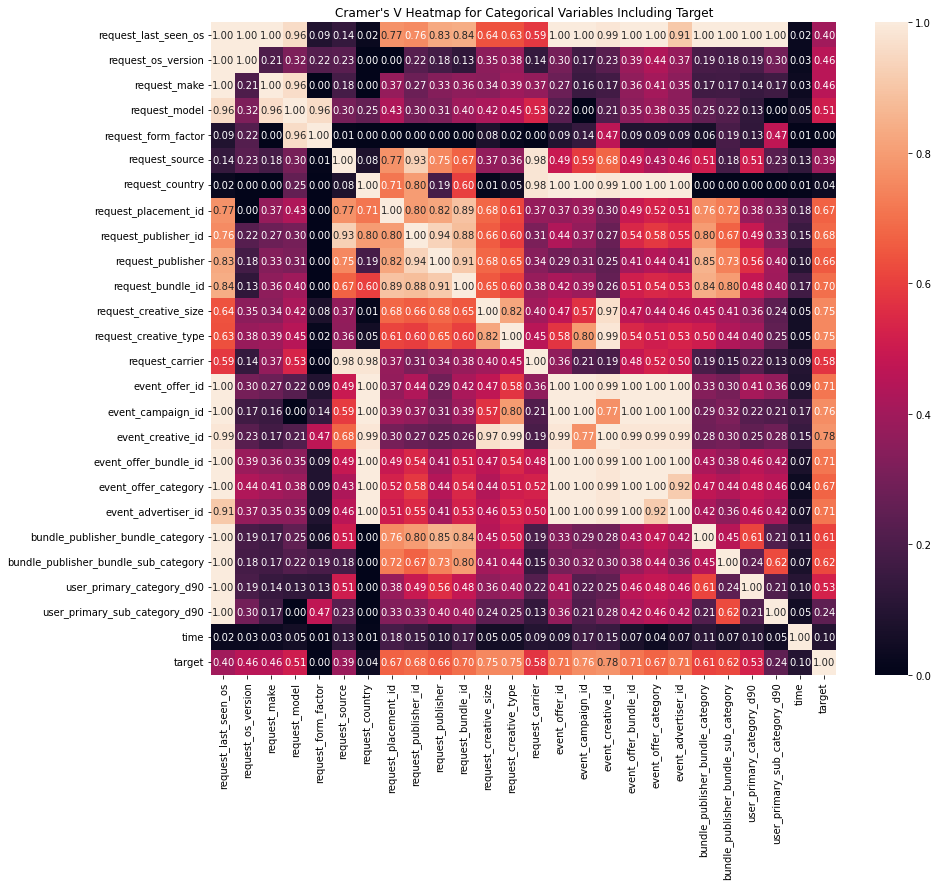

In [22]:
# Here we select only categorical columns and include the 'target' column
categorical_columns = data.select_dtypes(include=['category', 'object']).columns.tolist()
categorical_columns.append('target')  # Add the target variable

# Initialize the Cramer's V matrix
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Calculate Cramer's V for each pair of columns and fill in the matrix
for i in categorical_columns:
    for j in categorical_columns:
        if i != j:
            cramers_v_matrix.loc[i, j] = cramers_v(data[i], data[j])
        else:
            cramers_v_matrix.loc[i, j] = 1  # Association with itself is 1

# Convert the matrix to numeric values
cramers_v_matrix = cramers_v_matrix.apply(pd.to_numeric)

# Plotting the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f")
plt.title('Cramer\'s V Heatmap for Categorical Variables Including Target')
plt.show()

## Observations:
 Many of the Categorical variables have perfect (1.0) or near-perfect associations with each other. Essentially, these are duplicate versions of the same data. This will cause Multicollinearity in models that are sensitive to it. Also, having too many categorical variables (especially with hundreds and thousands of values, will make the number of one-hot encoded dimensions enormous.
- We need to eliminate quite a few of the columns. We will eliminate columns with a very weak association with "target" but also columns with high multicollinearity (very strong association with each other). For example: 
  - It makes sense that OS version and OS would have a perfect correlation, as the former is a subset of the latter.
  - Request Last Seen OS and OS are the same thing.
  - Phone Make, and OS should also be perfectly correlated since the latter is the subest of the former.
  - Since some offers are available only in some countries, request country and request offer bundle ID would be perfectly correlated, too. 
  - request_publisher_id, request_publisher and request_bundle_id essentially convey the same information (Publisher has 1x1 correspondence with Publisher ID and there is near 1x1 correspondance between Bundle ID and Publisher).
  - user_is_converter has a very weak association with Target because it is super sparse (mostly class 0)
  - The new "time" variable is not particularly useful either. The association with the target is weak.
 

In [23]:
# Let us get rid of the correlated columns
columns_to_delete = ['request_form_factor', 'request_os_version', 'request_last_seen_os',
                     'request_country', 'event_offer_bundle_id', 'request_model',
                    "request_publisher", "request_placement_id", "request_bundle_id",
                    "time", "request_creative_size", "user_is_converter",  
                    "user_primary_sub_category_d90", "request_source", "event_offer_id", 
                    "event_creative_id", "event_advertiser_id", 
                    "event_offer_category"]
data = data.drop(columns_to_delete, axis=1)

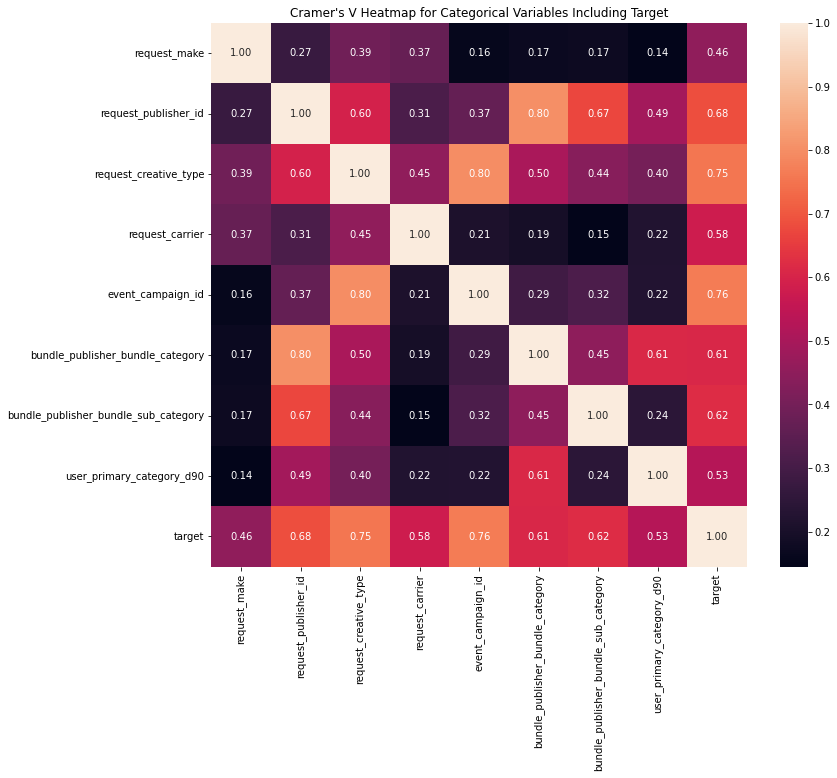

In [24]:
# let us rerun Cramer's V Matrix again: 
# Here we select only categorical columns and include the 'target' column
categorical_columns = data.select_dtypes(include=['category', 'object']).columns.tolist()
categorical_columns.append('target')  # Add the target variable

# Initialize the Cramer's V matrix
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Calculate Cramer's V for each pair of columns and fill in the matrix
for i in categorical_columns:
    for j in categorical_columns:
        if i != j:
            cramers_v_matrix.loc[i, j] = cramers_v(data[i], data[j])
        else:
            cramers_v_matrix.loc[i, j] = 1  # Association with itself is 1

# Convert the matrix to numeric values
cramers_v_matrix = cramers_v_matrix.apply(pd.to_numeric)

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f")
plt.title('Cramer\'s V Heatmap for Categorical Variables Including Target')
plt.show()

## Observations:
- the new matrix looks a lot cleaner:
   - we removed the variables that had weak association with "target"
   - also, removed the variables with strong multicollinearity
   

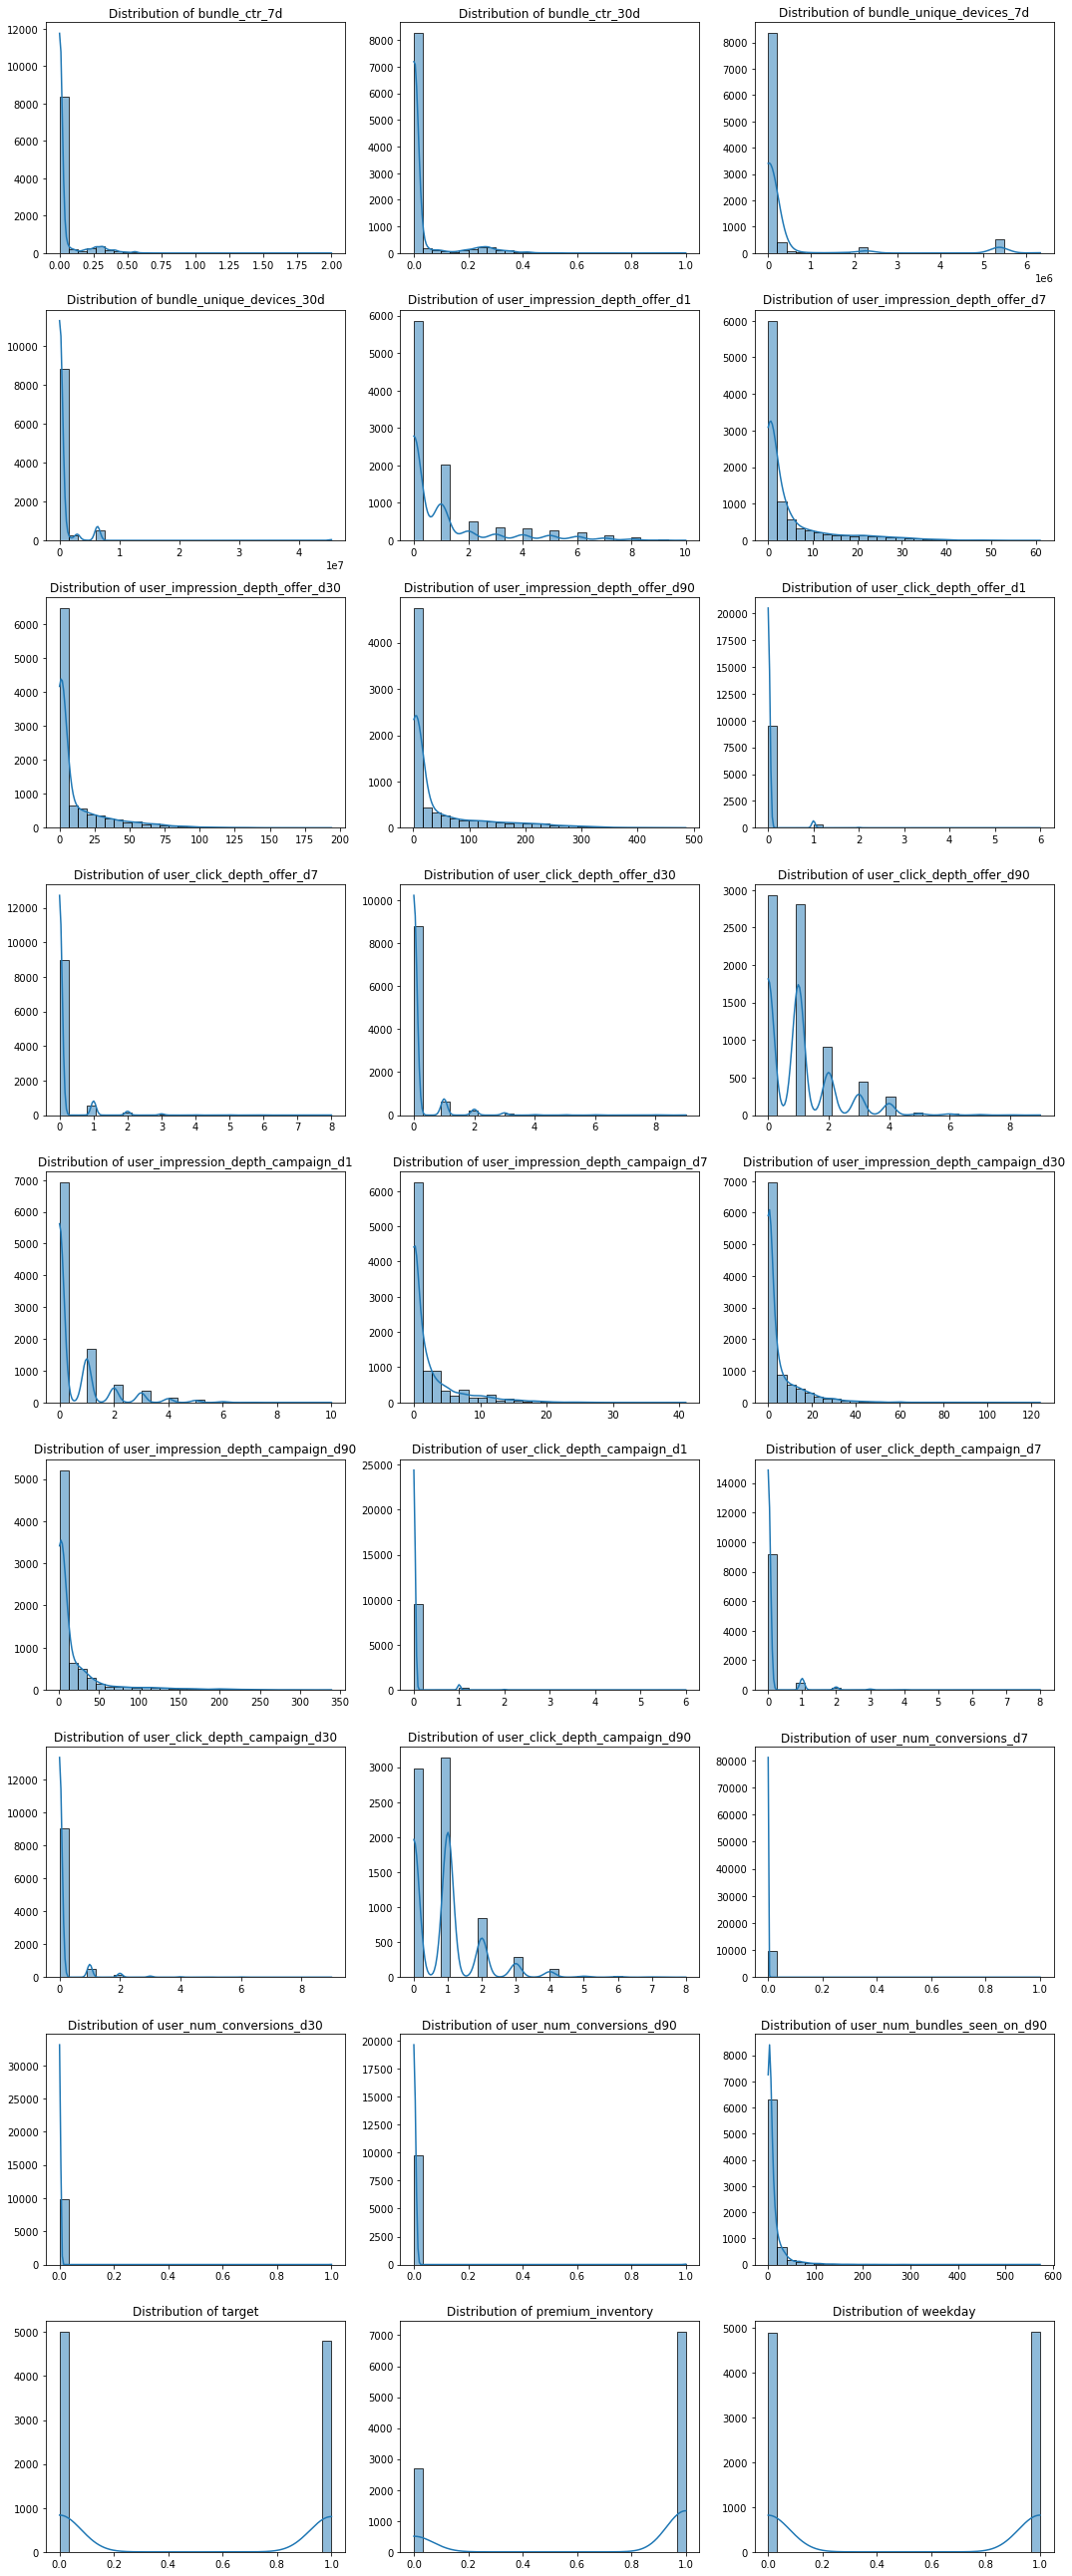

In [25]:
# Let us look at the distributions of numerical columns

# Select only the numerical columns from the DataFrame
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Number of rows and columns for the subplot grid
n_cols = 3
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot the distribution of each numerical column
for i, col in enumerate(numerical_columns):
    sns.histplot(data[col], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Hide any empty subplots
for i in range(len(numerical_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

## Observation:
- there is a lot of multicollinearity:
    - 'event_offer_id', 'event_creative_id', 'event_advertiser_id' and 'event_campaign_id' have near perfect correlation, since they are hierarchical objects.
    - user primary_sb_category_d90 is weak in terms of association with "target"
    - event_creative_id has near perfect correlation with request_creative_type

# Numerical and Boolean Variables - analysis and cleanup

In [26]:
# Convert columns with data type "bool" to integers (1 and 0)
for column in data.select_dtypes(include=['bool']).columns:
    data[column] = data[column].astype(int)

Let us see the Correlation matrix for the numerical (and former boolean) columns

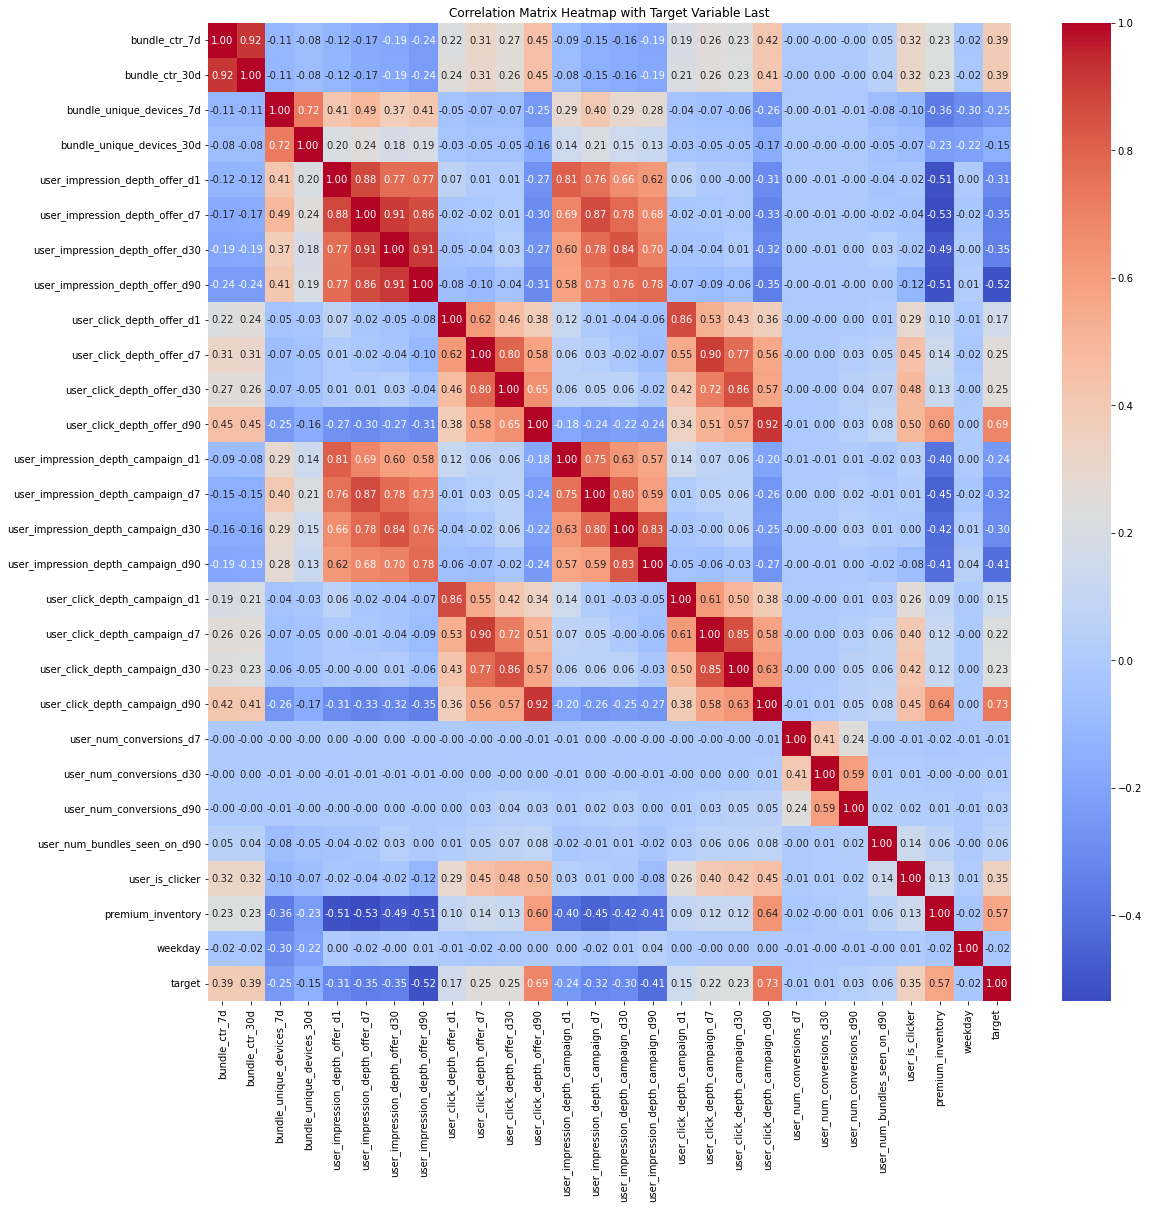

In [27]:
# Move the target column to the end
column_order = [col for col in data.columns if col != 'target'] + ['target']
data = data[column_order]

# Calculate the correlation matrix
corr = data.corr()

# Create a heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

# Adjust layout for better display
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Correlation Matrix Heatmap with Target Variable Last")

# Show the plot
plt.show()

## Observations:
- lots of variables have very weak correlation with "target". "Weak" is typically correlation under 0.30. To be conservative, let us eliminate columns with correlation to target less than 0.25 (in absolute value). Let us eliminate them
- There is strong multi-collinearity potential between some of the columns. Many of these are duplicate columns. We will need to get rid of some of them. 

In [28]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Extract the correlations with the 'target' column
target_corr = corr_matrix['target'].drop('target')  # Exclude self-correlation with 'target'

# Filter columns with weak correlation, i.e., in the range of -0.25 to 0.25
weak_correlated_columns = target_corr[target_corr.between(-0.25, 0.25)].index.tolist()

print(weak_correlated_columns)

['bundle_unique_devices_7d', 'bundle_unique_devices_30d', 'user_click_depth_offer_d1', 'user_impression_depth_campaign_d1', 'user_click_depth_campaign_d1', 'user_click_depth_campaign_d7', 'user_click_depth_campaign_d30', 'user_num_conversions_d7', 'user_num_conversions_d30', 'user_num_conversions_d90', 'user_num_bundles_seen_on_d90', 'weekday']


In [29]:
# Drop weakly correlated columns from the DataFrame
data = data.drop(columns=weak_correlated_columns)

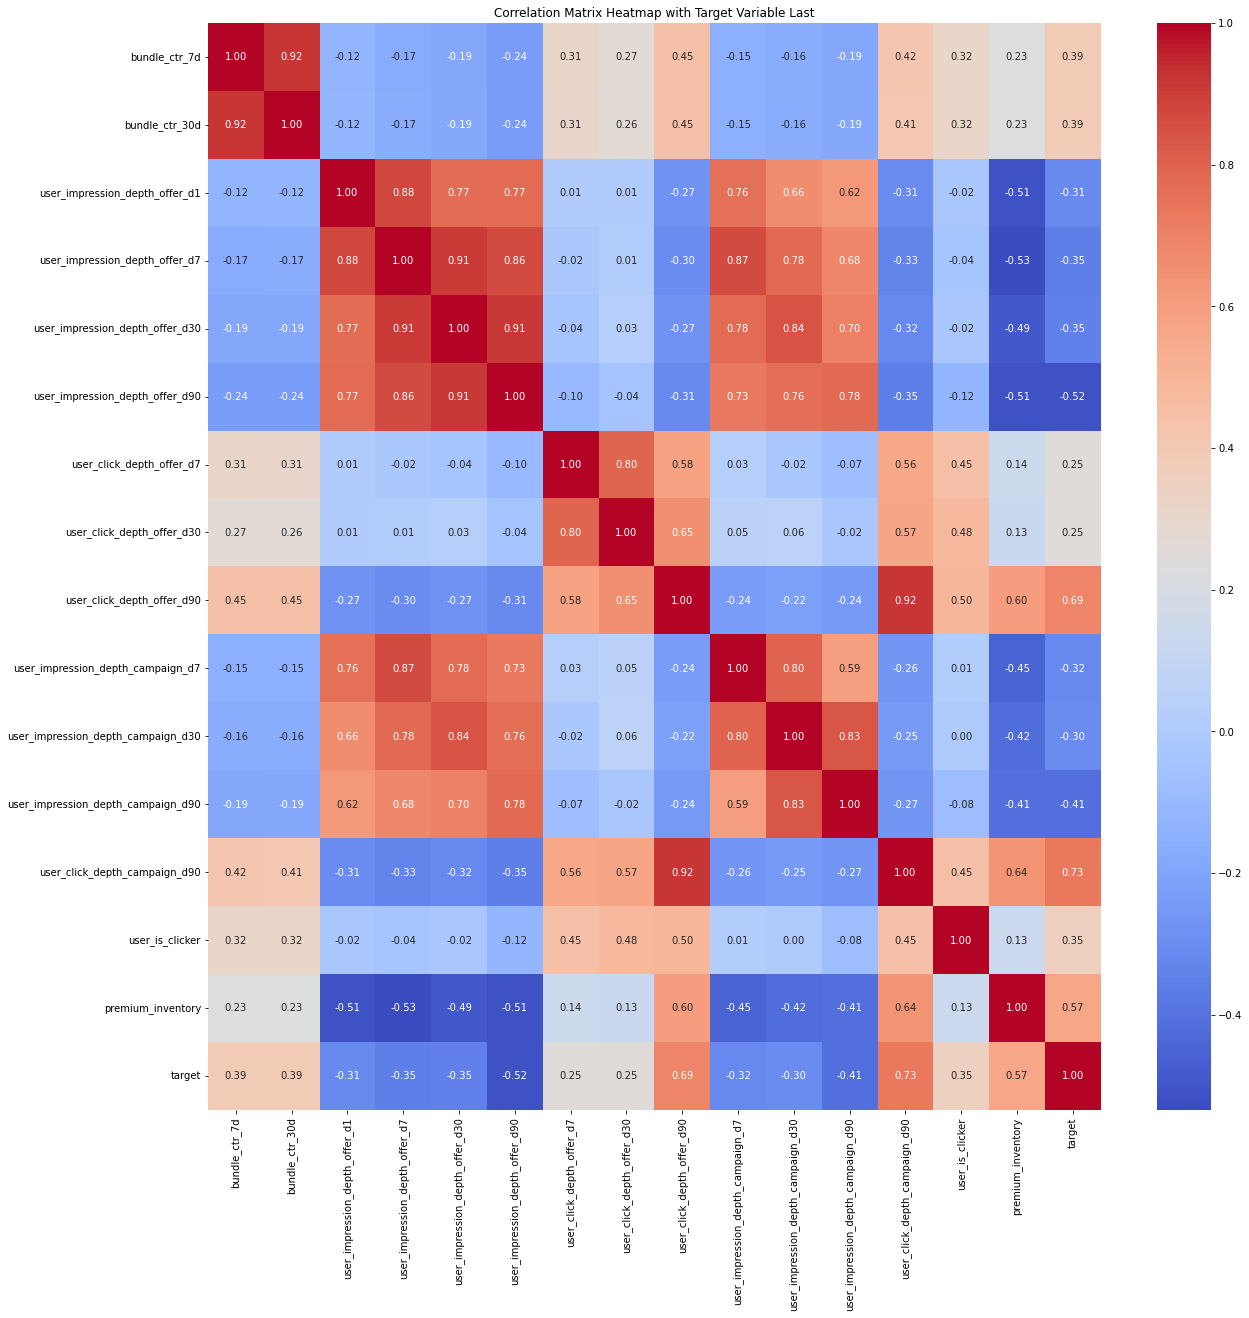

In [30]:
# Move the target column to the end
column_order = [col for col in data.columns if col != 'target'] + ['target']
data = data[column_order]

# Calculate the correlation matrix
corr = data.corr()

# Create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

# Adjust layout for better display
plt.xticks(rotation=90)  # Horizontal x-axis labels
plt.yticks(rotation=0)  # Horizontal y-axis labels
plt.title("Correlation Matrix Heatmap with Target Variable Last")

# Show the plot
plt.show()

## Observation:
- the matrix looks a lot cleaner (fewere weak variables).
- however, there are lots of columns that have strong correlation to each other. Many of these carry duplicate information and can cause multi-collinearity issue. 

Let us print the mumeric columns with the highest correlation to any other numeric columns (except for) the "target" column

In [31]:
# Calculate the correlation matrix and exclude the 'target' column
corr_matrix = data.drop(columns=['target']).corr()

# Create a Series to hold the maximum correlation of each column (excluding self-correlation)
max_corr = corr_matrix.apply(lambda x: x.drop(x.name).abs().max())

# Find the columns with a correlation above 0.6
columns_above_threshold = max_corr[max_corr > 0.6].index.tolist()

print(columns_above_threshold)

['bundle_ctr_7d', 'bundle_ctr_30d', 'user_impression_depth_offer_d1', 'user_impression_depth_offer_d7', 'user_impression_depth_offer_d30', 'user_impression_depth_offer_d90', 'user_click_depth_offer_d7', 'user_click_depth_offer_d30', 'user_click_depth_offer_d90', 'user_impression_depth_campaign_d7', 'user_impression_depth_campaign_d30', 'user_impression_depth_campaign_d90', 'user_click_depth_campaign_d90', 'premium_inventory']


## Observation:
- many of thee high correlation columns are versions of the same exact fields, except the use difrerent timeframe for the coutns: 1d, 7d, 30d and 90d. It is no surprise that they are very highly correlated to each-other. We need to keep only one of the columns of each type. 
- to decide which ones to keep, let us see which one of these have more non-null and non-zero values

In [32]:
# Loop through each numerical column and print the count of non-null, non-zero records
for column in data.select_dtypes(include=['number']).columns:
    count_non_null_non_zero = data[column].loc[data[column].notnull() & (data[column] != 0)].count()
    print(f"Column: {column}, Count of Non-Null & Non-Zero Records: {count_non_null_non_zero}")

Column: bundle_ctr_7d, Count of Non-Null & Non-Zero Records: 9380
Column: bundle_ctr_30d, Count of Non-Null & Non-Zero Records: 9588
Column: user_impression_depth_offer_d1, Count of Non-Null & Non-Zero Records: 3941
Column: user_impression_depth_offer_d7, Count of Non-Null & Non-Zero Records: 6235
Column: user_impression_depth_offer_d30, Count of Non-Null & Non-Zero Records: 6871
Column: user_impression_depth_offer_d90, Count of Non-Null & Non-Zero Records: 7422
Column: user_click_depth_offer_d7, Count of Non-Null & Non-Zero Records: 810
Column: user_click_depth_offer_d30, Count of Non-Null & Non-Zero Records: 1030
Column: user_click_depth_offer_d90, Count of Non-Null & Non-Zero Records: 4494
Column: user_impression_depth_campaign_d7, Count of Non-Null & Non-Zero Records: 5117
Column: user_impression_depth_campaign_d30, Count of Non-Null & Non-Zero Records: 5800
Column: user_impression_depth_campaign_d90, Count of Non-Null & Non-Zero Records: 7422
Column: user_click_depth_campaign_d90,

## Observation:
- four of the features have several versions: 1d, 7d, 30d, and 90d (where "d" stands for days)
- for these features, the higher-d versions have more volume, which is not surprising.
- the higher-d versions also have stronger correlation with target
- let us keep these versions

In [33]:
duplicate_num_cols = ['bundle_ctr_7d', 'user_impression_depth_offer_d1', 
                        'user_impression_depth_offer_d7', 'user_impression_depth_offer_d30',
                 'user_click_depth_offer_d7', 'user_click_depth_offer_d30',
                 'user_impression_depth_campaign_d7', 'user_impression_depth_campaign_d30',
                     'request_publisher_id', 'request_carrier']
data = data.drop(duplicate_num_cols, axis=1)

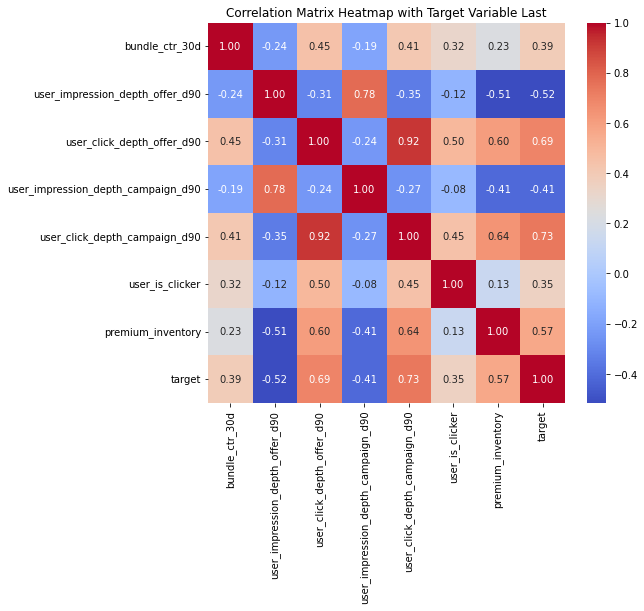

In [34]:
# Now let us see the Corrleation matrix again
# Move the target column to the end
column_order = [col for col in data.columns if col != 'target'] + ['target']
data = data[column_order]

# Calculate the correlation matrix
corr = data.corr()

# Create a heatmap
plt.figure(figsize=(8, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

# Adjust layout for better display
plt.xticks(rotation=90)  # Horizontal x-axis labels
plt.yticks(rotation=0)  # Horizontal y-axis labels
plt.title("Correlation Matrix Heatmap with Target Variable Last")

# Show the plot
plt.show()

## Observation:
- the numerical columns look a lot cleaner
- we have eliminated duplicate columns (version of the same data, but over a different timeframe
- we also eliminated columns with very weak correlation to 

# Univariate Analysis - Numerical Variables

In [35]:
# Let us write a function that will help us create boxplot and histogram for any input numerical variable.
# This function takes the numerical column as the input and return the boxplots and histograms for the variable.
def histogram_boxplot(feature, data=None, figsize=(15, 10), bins=None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    data: DataFrame containing the feature (default None)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows=2,
                                           sharex=True,
                                           gridspec_kw={"height_ratios": (.25, .75)},
                                           figsize=figsize)
    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color='violet')
    if bins:
        sns.histplot(data=data, x=feature, kde=False, ax=ax_hist2, bins=bins, palette="winter")
    else:
        sns.histplot(data=data, x=feature, kde=False, ax=ax_hist2, palette="winter")
    ax_hist2.axvline(data[feature].mean(), color='green', linestyle='--')
    ax_hist2.axvline(data[feature].median(), color='black', linestyle='-')
    
    # Set the chart title based on the feature name
    f2.suptitle(f'Histogram and Boxplot for {feature}', fontsize=16)

## Bi-variate Analysis

In [36]:
# Function to format text as bold
def make_bold(text):
    return f"\033[1m{text}\033[0m"

In [37]:
#A function to rended Stacked plot for Categorical variables in relation to "y"

def stacked_plot(x):
    sns.set(palette='nipy_spectral')
    
    #print header    
    header = make_bold(f'Breakdown for column "{column}" ')
    print(header)
    
    # Calculate and print the cross-tabulation (as numbers)
    tab1 = pd.crosstab(x, data['target'], margins=True)
    print(tab1)
    print('-' * 120)
    
    # Calculate the normalized cross-tabulation
    tab = pd.crosstab(x, data['target'], normalize='index')

    # Create a stacked bar chart
    tab.plot(kind='bar', stacked=True, figsize=(18,5))
    
    plt.legend(loc='lower left', frameon=False)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    
    # Dynamically populate the column name into the title
    plt.title(f'Stacked Bar Chart for Column "{x.name}" ')
    
    plt.show()
    print('=' * 120)
    print('=' * 120)

In [38]:
# Identify categorical columns, excluding 'y'
cat_features = [col for col in data.select_dtypes(include=['category', 'object']).columns if col != 'target']

Breakdown for column "request_make" 
target           0     1   All
request_make                  
AT&T             4     3     7
Alcatel         14     7    21
Apple         2507   612  3119
Asus             0     6     6
Azom Tech        0     1     1
Blackview        0     2     2
Blu              6    12    18
Bmobile          0     2     2
CAT              1     0     1
Coolpad          2     6     8
Cricket          2    13    15
Cubot            0     1     1
Dish             2     7     9
Essential        0     1     1
Gionee           0     1     1
Google          55    46   101
HTC              0     3     3
Hot Pepper       0     1     1
Huawei           6   140   146
Infinix          1    16    17
Itel             0     2     2
Jio              0     1     1
Kyocera          2     0     2
LG              59    92   151
LT               0     2     2
Lephone          0     1     1
Logic            0     1     1
Meizu            5    14    19
Motorola       403   550   953
No

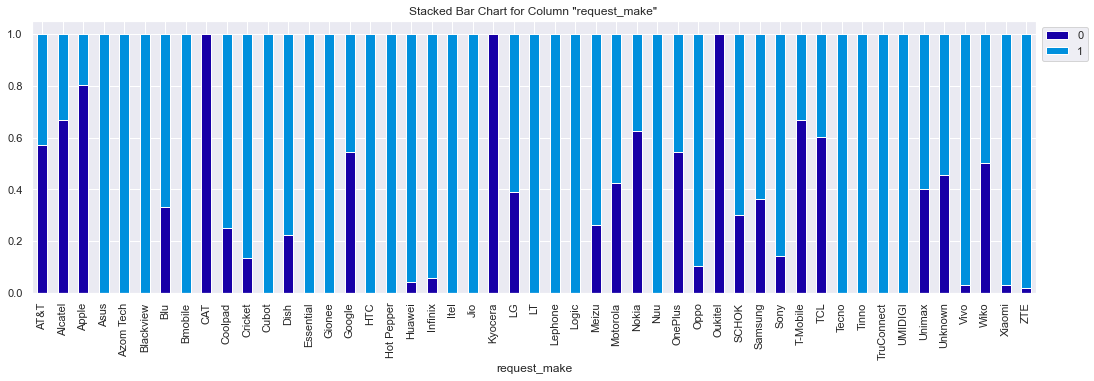

Breakdown for column "request_creative_type" 
target                    0     1   All
request_creative_type                  
Banner                 3836   798  4634
Interstitial            274  2223  2497
Native                  827   106   933
Video                    63  1677  1740
All                    5000  4804  9804
------------------------------------------------------------------------------------------------------------------------


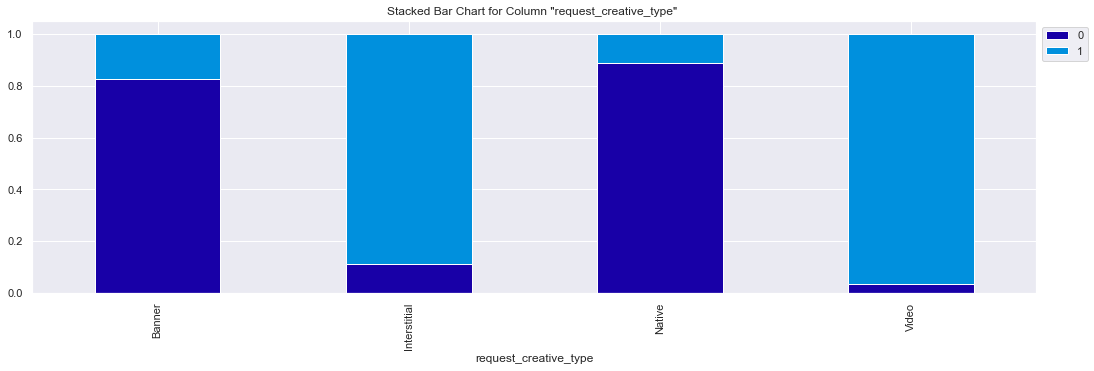

Breakdown for column "event_campaign_id" 
target                0     1   All
event_campaign_id                  
8465                  2     0     2
11080              1127   281  1408
11083               174    55   229
11304                84     5    89
11327                 4     7    11
...                 ...   ...   ...
13441                 2    13    15
13442                 0    13    13
13443                 3     4     7
13451                 4     1     5
All                5000  4804  9804

[77 rows x 3 columns]
------------------------------------------------------------------------------------------------------------------------


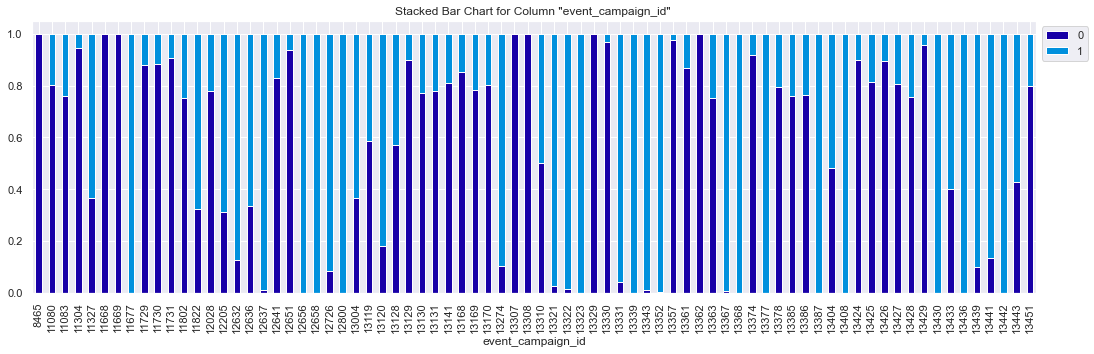

Breakdown for column "bundle_publisher_bundle_category" 
target                               0     1   All
bundle_publisher_bundle_category                  
10                                   1     1     2
11                                   0     4     4
12                                   9    10    19
13                                   3     4     7
14                                  30   167   197
15                                   2    12    14
16                                  18    91   109
162                                 43    49    92
18                                   9    19    28
2                                  641  2396  3037
21                                  16    86   102
22                                  17     3    20
23                                  10    90   100
24                                  13    13    26
25                                   8    37    45
27                                   7    57    64
29                       

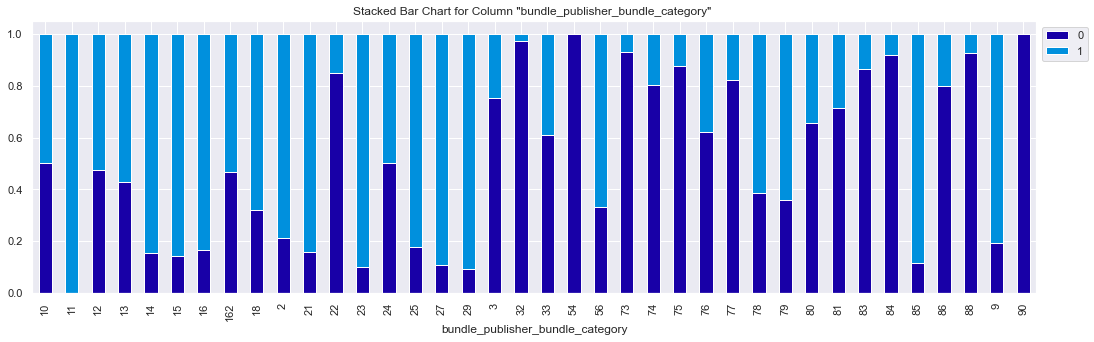

Breakdown for column "bundle_publisher_bundle_sub_category" 
target                                   0     1   All
bundle_publisher_bundle_sub_category                  
100                                    376    67   443
101                                    527    77   604
102                                    101   148   249
106                                     19     3    22
107                                      0     1     1
108                                    410    33   443
110                                      8     1     9
111                                      5     4     9
112                                      4     0     4
113                                      1     0     1
114                                     22     2    24
115                                     11     0    11
28                                      14    34    48
34                                      55   177   232
35                                       0     3     3
36  

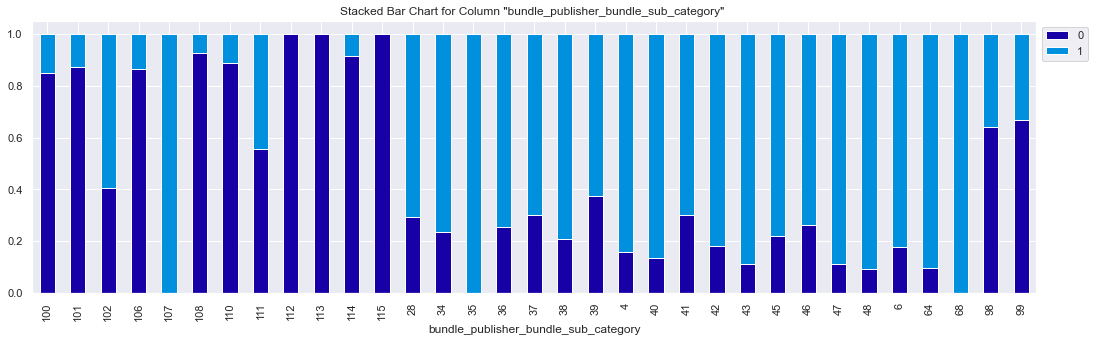

Breakdown for column "user_primary_category_d90" 
target                        0     1   All
user_primary_category_d90                  
2.0                         748  2549  3297
3.0                        1173   478  1651
9.0                          19    60    79
10.0                          1     1     2
11.0                          1     9    10
12.0                         15    26    41
13.0                          3     5     8
14.0                         26   112   138
15.0                          3    10    13
16.0                         12    85    97
18.0                         10    17    27
21.0                         18    81    99
22.0                        306    32   338
23.0                          7    42    49
24.0                          7    13    20
25.0                         11    56    67
26.0                          1     0     1
27.0                          9    50    59
29.0                         66   494   560
32.0                      

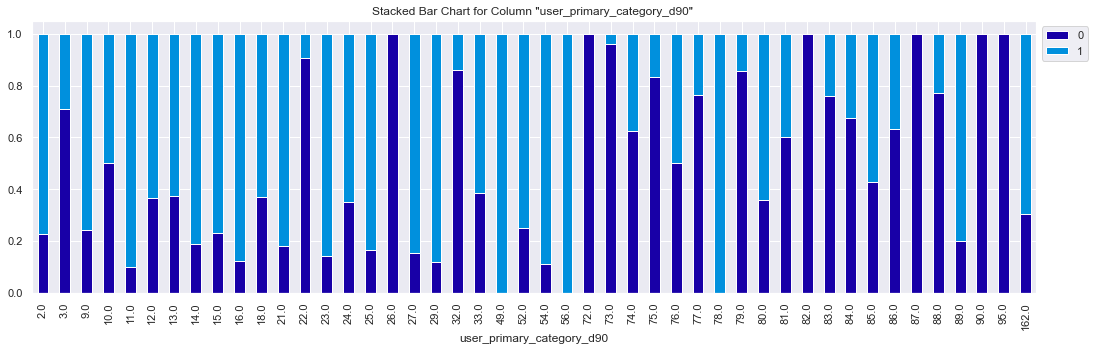

In [39]:
for column in cat_features:
    stacked_plot(data[column])

## Observations:
- requst make, requst creative type, campaign ID, request carrier, bundle category, bundle subcategory, and user primary category d_90 appear to be significantly impacting the probability of Click
- publisher ID has too many values for us to visualize

# Univariate Analysis - Numerical Variables

In [40]:
# Let us write a function that will help us create boxplot and histogram for any input numerical variable.
# This function takes the numerical column as the input and return the boxplots and histograms for the variable.
def histogram_boxplot(feature, data=None, figsize=(15, 10), bins=None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    data: DataFrame containing the feature (default None)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows=2,
                                           sharex=True,
                                           gridspec_kw={"height_ratios": (.25, .75)},
                                           figsize=figsize)
    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color='violet')
    if bins:
        sns.histplot(data=data, x=feature, kde=False, ax=ax_hist2, bins=bins, palette="winter")
    else:
        sns.histplot(data=data, x=feature, kde=False, ax=ax_hist2, palette="winter")
    ax_hist2.axvline(data[feature].mean(), color='green', linestyle='--')
    ax_hist2.axvline(data[feature].median(), color='black', linestyle='-')
    
    # Set the chart title based on the feature name
    f2.suptitle(f'Histogram and Boxplot for {feature}', fontsize=16)

In [41]:
# Select only the numerical columns from the DataFrame
numerical_col = data.select_dtypes(include=['float64', 'int64']).columns

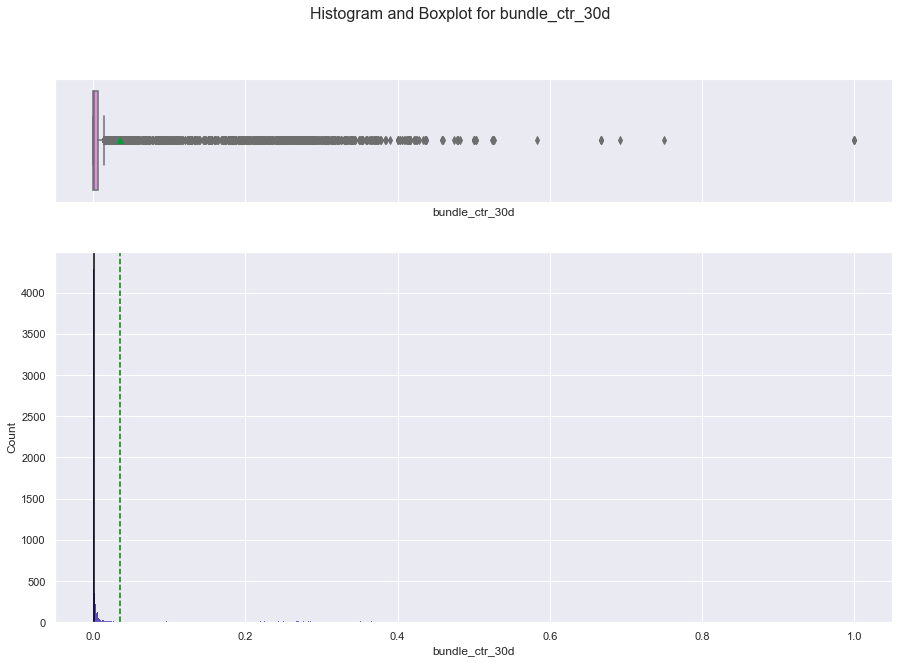

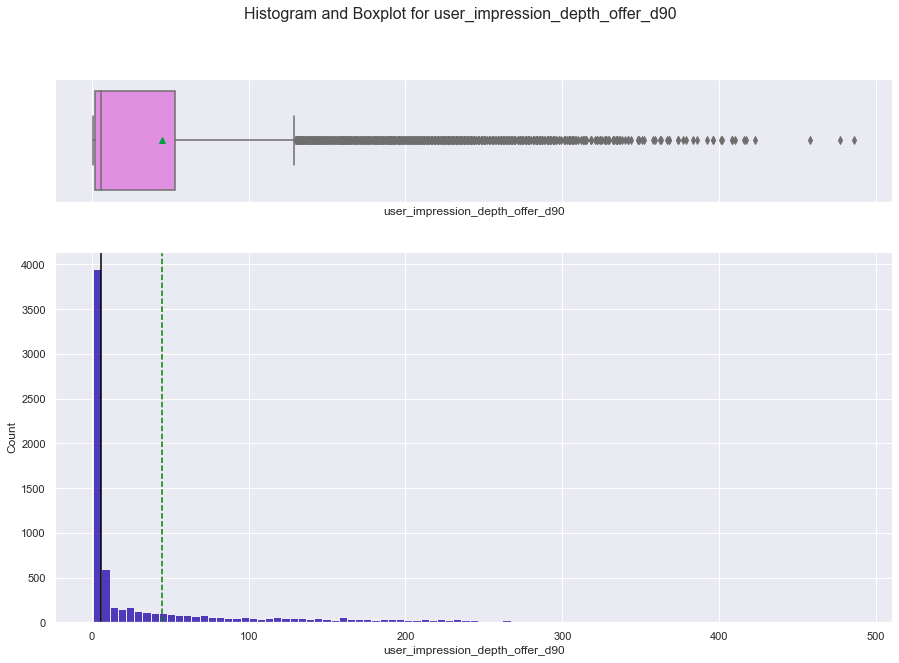

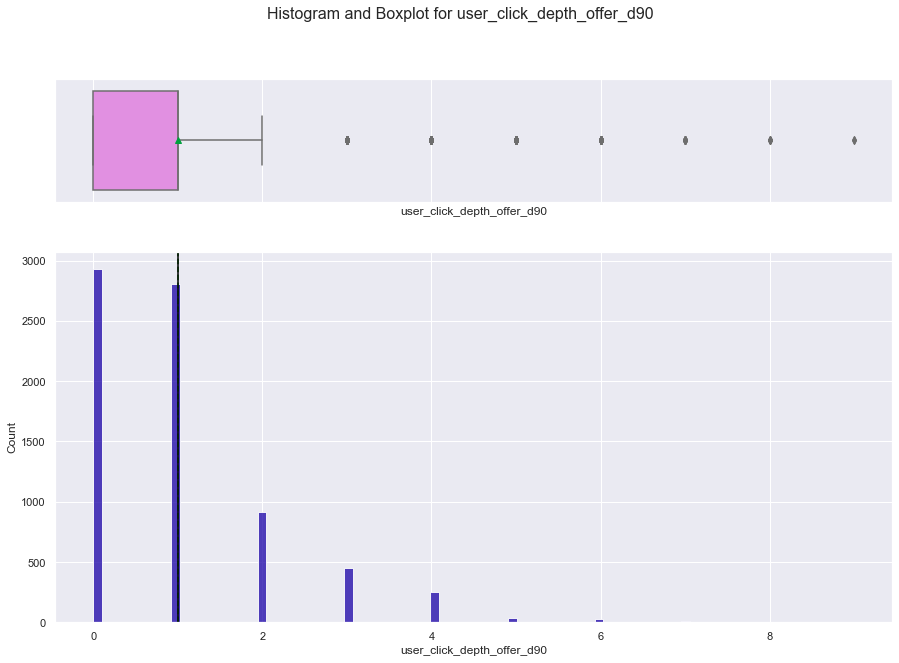

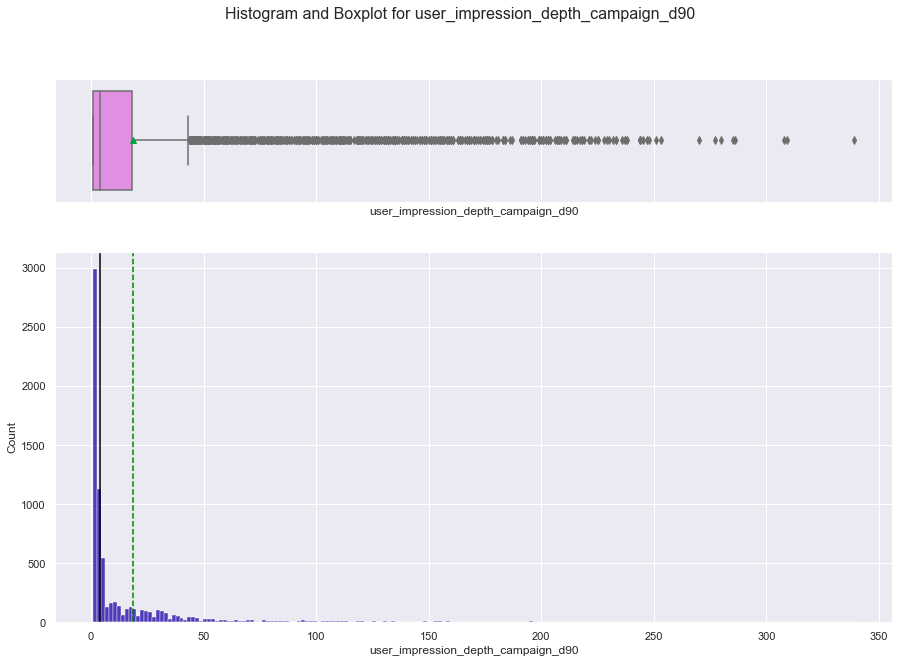

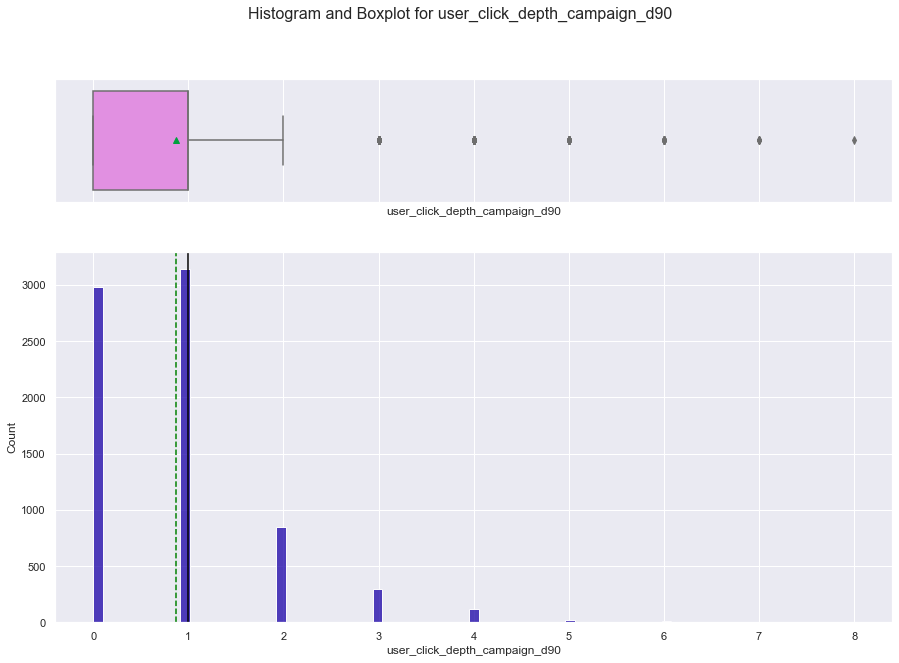

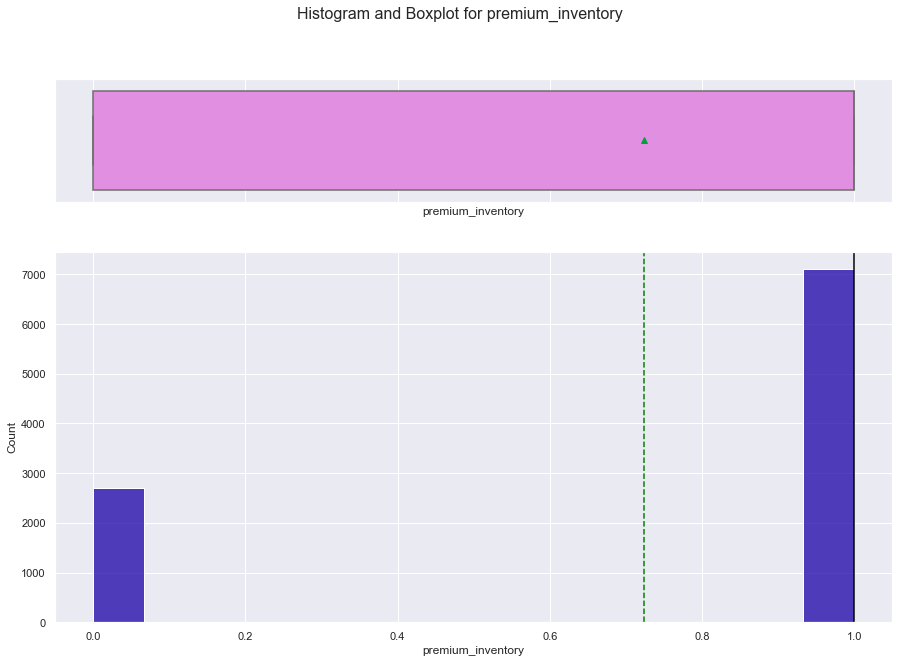

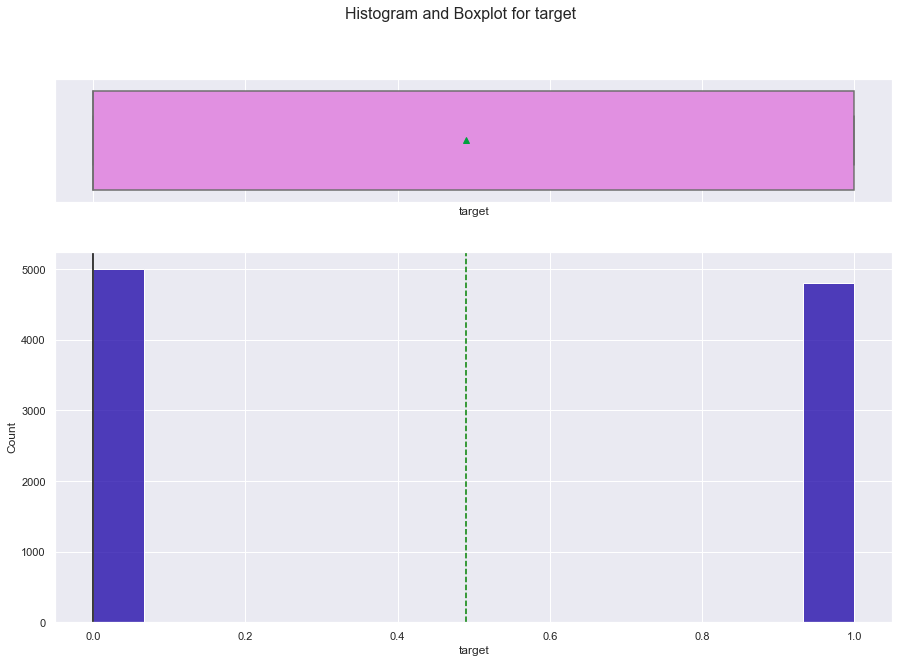

In [42]:
# Build the histogram boxplots for all numerical columns
for col in numerical_col:
    histogram_boxplot(col, data=data)

## Observations:
- All Numecial columns except for the two binary columns (target and premium_inventory) area heavily right-skewed and contain a lot of outliers. We will have to do Log transformaiton for them.

In [44]:
#Let us export the datafraome to .csv
data.to_csv(r"C:\Users\dkaza\Documents\0 Berkeley - ML and AI\0_Capstone\clean.csv", index=False)